# Threshold Selection Based On Predicted Default Rate

In [9]:
random_state = 123
X = continue_tree_raw.drop('loan_status',axis=1)
y = continue_tree_raw['loan_status']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=random_state)
X_train = X_train.drop('total_pymnt',axis=1)

total_payments = X_test['total_pymnt']
X_test = X_test.drop('total_pymnt', axis=1)

xg = xgb.XGBClassifier(eta = 0.15,
                       max_depth = 6,
                       min_child_weight=4,
                       gamma=1.6,
                       colsample_bytree=0.9,
                       subsample=0.6,
                       reg_alpha=0.2,
                       reg_lambda=1)
oversampler = RandomOverSampler(sampling_strategy='minority')
X_train,y_train = oversampler.fit_resample(X_train,y_train)
xg.fit(X_train,y_train)
xg_calibration = CalibratedClassifierCV(xg, cv=5, method='sigmoid')
xg_calibration.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    callbacks=None,
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=0.9,
                                                    early_stopping_rounds=None,
                                                    enable_categorical=False,
                                                    eta=0.15, eval_metric=None,
                                                    gamma=1.6, gpu_id=-1,
                                                    grow_policy='depthwise',
                                                    importance_type=None,
                                                    interaction_constraints='',
                                

In [27]:
predicted_prob = xg_calibration.predict_proba(X_test)[:,1]
X_test = pd.DataFrame(X_test)
predicted_prob = pd.DataFrame(predicted_prob, columns=['Output'])
total_payments = pd.DataFrame(total_payments)
X_select = X_test.loc[:,['loan_amnt','term']]
X_test_return_cal = pd.concat([y_test.reset_index(drop=True), X_select.reset_index(drop=True),
                               total_payments.reset_index(drop=True), predicted_prob.reset_index(drop=True)],
                              axis=1)

# Resume the true value of the categorical variable "term"
X_test_return_cal['term'].replace(0, 3, inplace=True)
X_test_return_cal['term'].replace(1, 5, inplace=True)

# Calculate the annual return for each loan and create a new column
X_test_return_cal['annualized_return'] = ((X_test_return_cal['total_pymnt'] / X_test_return_cal['loan_amnt']) **
                                          (1/X_test_return_cal['term']) - 1) * 100
list_1 = [x/100 for x in range(0, 100, 1)]
return_output = []

# Based on the after-calibrated Predicted Default Rate, we sort clients into 100 groups, and then we calculate the average return for each group
# that each group can provide.
for i in list_1:
    cond1 = X_test_return_cal['Output'] > i
    cond2 = X_test_return_cal['Output'] < i + 0.01
    return_avg = X_test_return_cal.loc[cond1 & cond2, 'annualized_return'].mean()
    return_output.append(return_avg)

In [25]:
# Then we map each group's Predicted Default Rate with its annual return into return_output_1
return_output_1 = [float(i) for i in return_output]
return_output_1 = pd.DataFrame(return_output_1, index= list_1, columns = ['Avg. Returns on loans'])

# Then we find the highest return among all groups
return_max = return_output_1['Avg. Returns on loans'].max()
return_max

1.5073040696647781

In [33]:
# To achieve the highest annual return, we select a predicted default rate of 12% as our optimal threshold
threshold_max = return_output_1[return_output_1['Avg. Returns on loans'] == return_max]
threshold_max_1 = threshold_max.index.tolist()[0]
threshold_max

,Avg. Returns on loans
0.12,1.507304


In [14]:
return_above_zero = return_output_1.copy()
return_above_zero[return_above_zero['Avg. Returns on loans'] < 0] = 0
return_below_zero = return_output_1.copy()
return_below_zero[return_below_zero['Avg. Returns on loans'] > 0] = 0

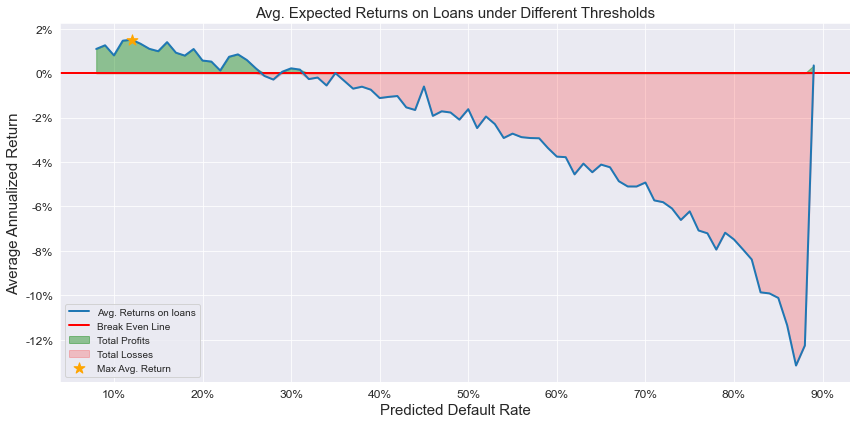

In [20]:
return_output_1.plot(label = 'Avg. Returns on loans', figsize=(12,6), grid=True, linewidth=2, fontsize=12, zorder=3)
plt.axhline(y=0, color='r', linestyle='-',linewidth=2,label='Break Even Line', zorder=2)
plt.fill_between(return_output_1.index, 0, return_above_zero['Avg. Returns on loans'], color='green', alpha=0.4, label='Total Profits', zorder=1)
plt.fill_between(return_output_1.index, 0, return_below_zero['Avg. Returns on loans'], color='red', alpha=0.2, label='Total Losses', zorder=1)
plt.xticks([x/10 for x in range(0, 11, 1)], ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%' , '90%', '100%'])
plt.yticks([*range(-16, 5, 2)], ['-16%', '-14%', '-12%', '-10%', '-8%', '-6%', '-4%', '-2%', '0%' , '2%', '4%'])
plt.scatter(threshold_max_1, return_max, marker = "*", s = 130, c = "orange", label = "Max Avg. Return", zorder=4)
plt.xlabel('Predicted Default Rate', fontsize=15)
plt.ylabel('Average Annualized Return', fontsize=15)
plt.title('Avg. Expected Returns on Loans under Different Thresholds', fontsize=15)
plt.legend()
plt.tight_layout()
plt.show()